In [1]:
import d2lzh as d2l
from mxnet import autograd,gluon,init,nd
from mxnet.gluon import data as gdata,loss as gloss,nn
import numpy as np
import pandas as pd

In [2]:
train_data=pd.read_csv(r'E:\ML_Dataset\house-prices-advanced-regression-techniques\train.csv')
test_data=pd.read_csv(r'E:\ML_Dataset\house-prices-advanced-regression-techniques\test.csv')
train_data.shape,test_data.shape

((1460, 81), (1459, 80))

In [3]:
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


#### 将79个特征按样本连结 

In [4]:
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
all_features.shape

(2919, 79)

In [5]:
#数据预处理

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)



In [6]:
all_features=pd.get_dummies(all_features,dummy_na=True)
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

#### 线性回归模型+平方损失函数 

In [7]:
loss=gloss.L2Loss()
def get_net():
    net=nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [8]:
def log_rmse(net,features,labels):
    clipped_preds=nd.clip(net(features),1,float('inf'))
    rmse=nd.sqrt(2*loss(clipped_preds.log(),labels.log()).mean())
    return rmse.asscalar()

In [9]:
def train(net,train_features,train_labels,test_features,test_labels,
         num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    train_iter=gdata.DataLoader(gdata.ArrayDataset(train_features,train_labels),
                               batch_size,shuffle=True)
    #使用了Adam优化算法
    trainer=gluon.Trainer(net.collect_params(),'adam',{
        'learning_rate':learning_rate,'wd':weight_decay
    })
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l=loss(net(X),y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls
        

#### K折交叉验证 

In [10]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

In [11]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net()
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0:
            d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse',
                         range(1,num_epochs+1),valid_ls,['train','valid'])
        print('fold %d,train rmse %f,valid rmse %f'%(i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

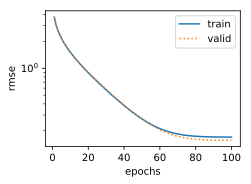

fold 0,train rmse 0.169889,valid rmse 0.156649
fold 1,train rmse 0.162001,valid rmse 0.188321
fold 2,train rmse 0.163473,valid rmse 0.167983
fold 3,train rmse 0.167638,valid rmse 0.154792
fold 4,train rmse 0.162636,valid rmse 0.182907
5-fold validation:avg train rmse 0.165128,avg valid rmse 0.170130


In [12]:
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation:avg train rmse %f,avg valid rmse %f'%(k,train_l,valid_l))

In [19]:
def train_and_pred(train_features,test_features,train_labels,
                    test_data,num_epochs,lr,weight_decay,batch_size):
    net=get_net()
    train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse')
    print('train rmse %f'%train_ls[-1])
    preds=net(test_features).asnumpy()
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('submission.csv',index=False)

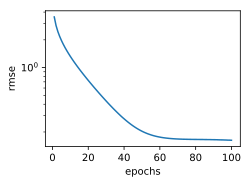

train rmse 0.162509


In [20]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)